#  Прогнозирование заказов такси

## Подготовка

In [72]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import lightgbm as lgb
import catboost as cat
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import seasonal_decompose
import time
from itertools import product
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pt = PowerTransformer()

In [2]:
taxi_df = pd.read_csv("/datasets/taxi.csv", index_col = [0], parse_dates = [0])
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [14]:
taxi_df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [5]:
taxi_df = taxi_df.sort_index()

In [6]:
taxi_df.index.is_monotonic

True

In [7]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проведем ресемплирование данных, так как их периодичность 10 мин

In [8]:
taxi_df = taxi_df.resample("1H").sum()

Cоздадим переменные для копий датафрейма для дальнейшего сравнения

In [9]:
df_new = taxi_df.copy()
final_df = taxi_df.copy()

In [21]:
taxi_df["rolling_mean"] = taxi_df["num_orders"].rolling(20).mean()
taxi_df["rolling_std"] = taxi_df["num_orders"].rolling(20).std()

In [10]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


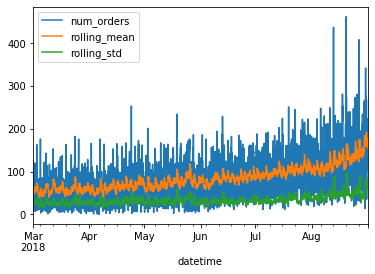

In [22]:
taxi_df.plot()
plt.show()

In [12]:
decomposed = seasonal_decompose(final_df["num_orders"])

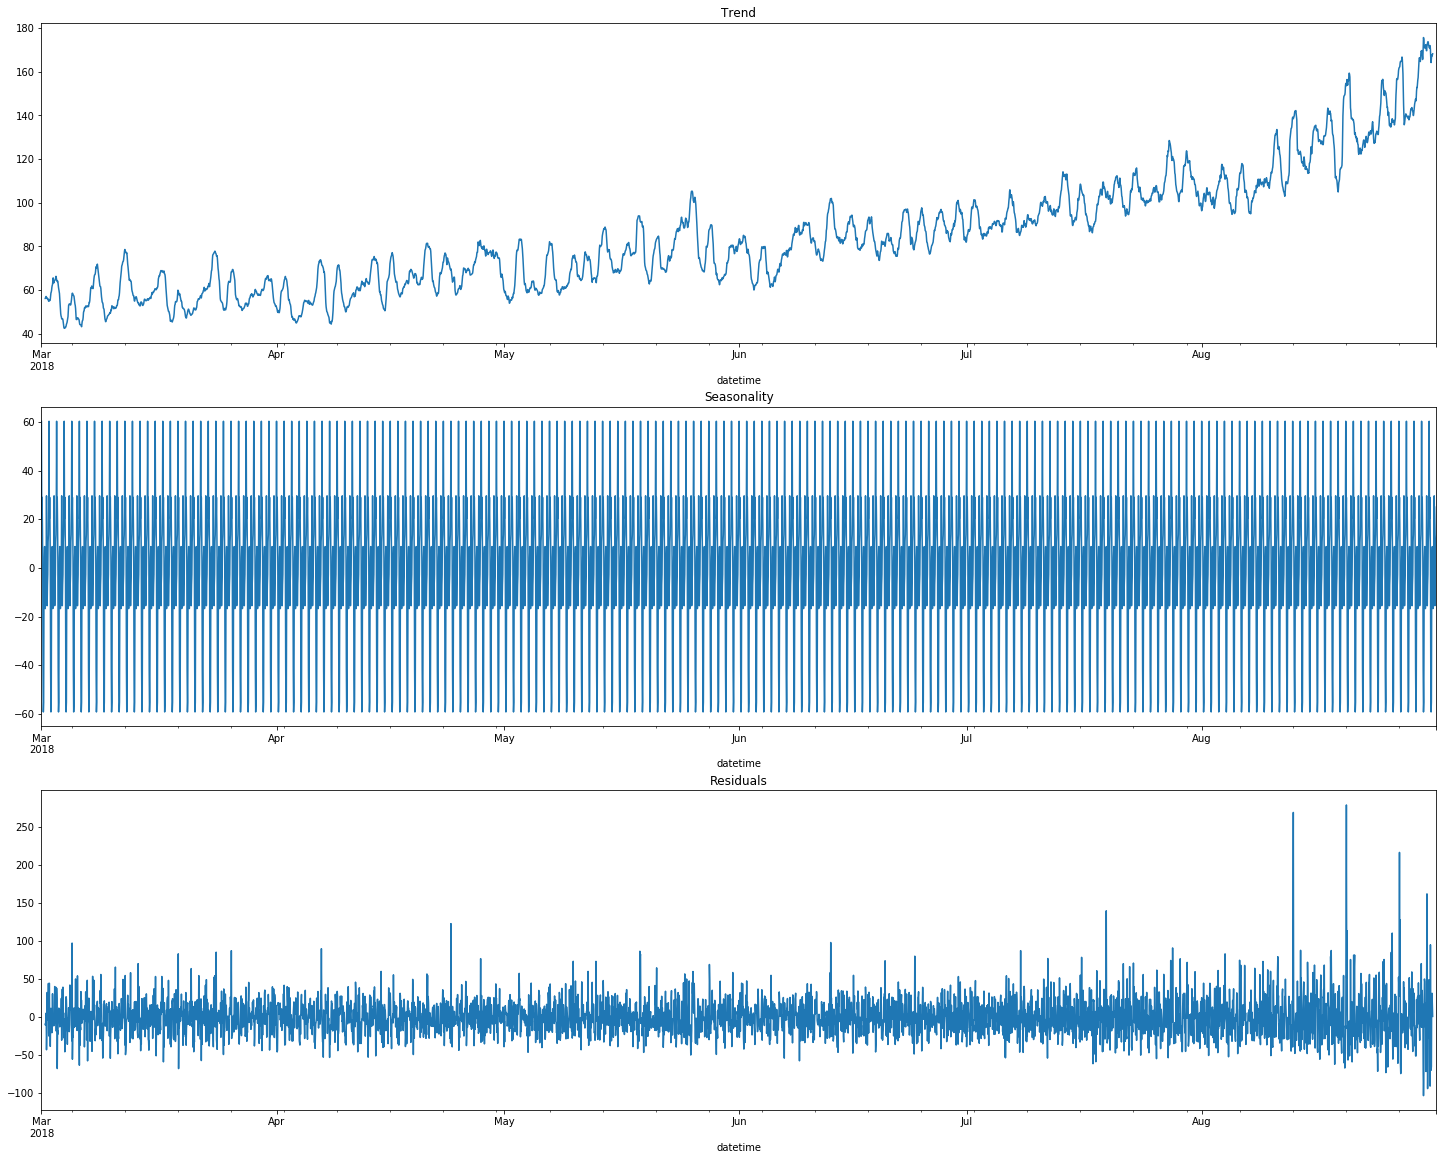

In [13]:
fig,ax = plt.subplots(3,1,figsize = (25,20))
decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

In [28]:
decomposed = seasonal_decompose(final_df)
decomposed1Week = seasonal_decompose(final_df['2018-03-04':'2018-03-12'])
decomposed3Days = seasonal_decompose(final_df['2018-03-04':'2018-03-06'])
decomposedApril = seasonal_decompose(final_df['2018-04-01':'2018-05-01'])
decomposedAugust = seasonal_decompose(final_df['2018-07-31':'2018-08-31'])

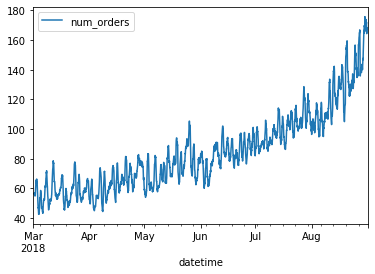

In [29]:
decomposed.trend.plot()

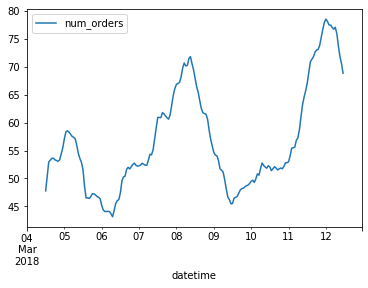

In [31]:
decomposed1Week.trend.plot()

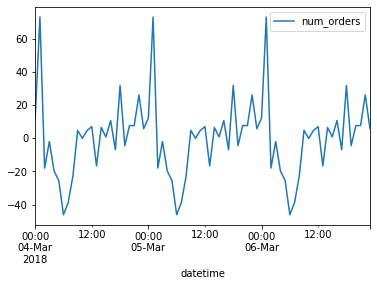

In [32]:
decomposed3Days.seasonal.plot()

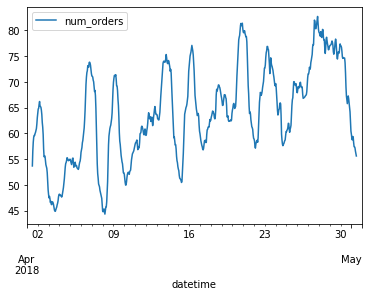

In [33]:
decomposedApril.trend.plot()

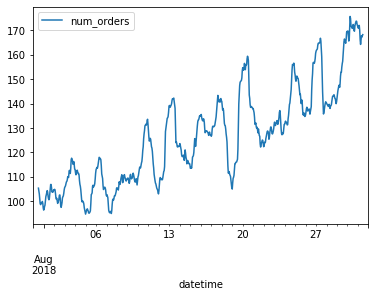

In [34]:
decomposedAugust.trend.plot()

### Вывод 1

Данные подготовлены к анализу, проведено ресемплирование, созданы копии датафрейма

## Анализ

Судя по графику rolling_mean и rolling_std ряд стационарен, проверим как будет выглядеть ряд после применения сдвига

In [ ]:
#df_new = taxi_df - taxi_df.shift()

In [ ]:
#df_new["rolling_mean"] = df_new["num_orders"].rolling(20).mean()
#df_new["rolling_std"] = df_new["num_orders"].rolling(20).std()

In [ ]:
df_new.plot()

In [23]:
adfuller(taxi_df["num_orders"])

(-3.0689242890279558,
 0.028940051402612906,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

In [24]:
ts = final_df['num_orders']
st_test = adfuller(ts, regression = 'ctt')

Проверяем ряд на стационарность. adfuller позволяет провести unit root test для того, чтобы сделать вывод стационарен ряд или нет. я как то проверял на стационарность по другой задаче еще и другим тестом - Phillips–Perron test, но его валидность оказалась очень слабой.

In [25]:
print('Если значение < P-Value, при пороге 0.05 - ряд стационарный')
if st_test[1] < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение < P-Value, при пороге 0.05 - ряд стационарный
Ряд стационарный


In [26]:
df_new.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Исследуем, какие признаки нам понадобится. Признак day будет необходим, так как очевидна внутридневная сезонность. dayofweek потребуется, в силу того, что тренд показывает увеличение заказовк концу недели. Признак month потребуеся, так какиз месяца в месяц данные носят цикличный характер.
Найдем разницу в часах между максимальным значением ночью и минимальным значением в сезонном сегменте для расчета количества lag признаков.

In [39]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [40]:
make_features(final_df,24,20)

In [ ]:
decomposed = seasonal_decompose(final_df["num_orders"])

Рассмотрим графики тренда , сезонности и остатков

In [ ]:
fig,ax = plt.subplots(3,1,figsize = (25,20))
decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

Также рассмотрим срез данных с "2018-03-05" по "2018-04-29". При рассмотрении недель возьмем даты с понедельника по воскресенье - с 5 марта по 29 апреля. Рассмотрим их на осях количество заказов и день недели.

In [ ]:
decomposed_short = seasonal_decompose(final_df["2018-03-05":"2018-04-29"]["num_orders"])
fig2,ax2 = plt.subplots(8,2,figsize = (25,60))

ax2[0][0].plot(decomposed_short.trend["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.trend["2018-03-05":"2018-03-11"].values,linewidth = 4)
ax2[0][0].set_title("Trend: первая неделя марта")

ax2[1][0].plot(decomposed_short.trend["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.trend["2018-03-12":"2018-03-18"].values,linewidth = 4)
ax2[1][0].set_title("Trend: вторая неделя марта")

ax2[2][0].plot(decomposed_short.trend["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.trend["2018-03-19":"2018-03-25"].values,linewidth = 4)
ax2[2][0].set_title("Trend: третья неделя марта")

ax2[3][0].plot(decomposed_short.trend["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.trend["2018-03-26":"2018-04-01"].values,linewidth = 4)
ax2[3][0].set_title("Trend: четвертая неделя марта")

ax2[0][1].plot(decomposed_short.trend["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.trend["2018-04-02":"2018-04-08"].values,linewidth = 4)
ax2[0][1].set_title("Trend: первая неделя апреля")

ax2[1][1].plot(decomposed_short.trend["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.trend["2018-04-09":"2018-04-15"].values,linewidth = 4)
ax2[1][1].set_title("Trend: вторая неделя апреля")

ax2[2][1].plot(decomposed_short.trend["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.trend["2018-04-16":"2018-04-22"].values,linewidth = 4)
ax2[2][1].set_title("Trend: третья неделя апреля")

ax2[3][1].plot(decomposed_short.trend["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.trend["2018-04-23":"2018-04-29"].values,linewidth = 4)
ax2[3][1].set_title("Trend: четвертая неделя апреля")

ax2[4][0].plot(decomposed_short.seasonal["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.seasonal["2018-03-05":"2018-03-11"].values,linewidth = 4)
ax2[4][0].set_title("Seasonality: первая неделя марта")

ax2[5][0].plot(decomposed_short.seasonal["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.seasonal["2018-03-12":"2018-03-18"].values,linewidth = 4)
ax2[5][0].set_title("Seasonality: вторая неделя марта")

ax2[6][0].plot(decomposed_short.seasonal["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.seasonal["2018-03-19":"2018-03-25"].values,linewidth = 4)
ax2[6][0].set_title("Seasonality: третья неделя марта")

ax2[7][0].plot(decomposed_short.seasonal["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.seasonal["2018-03-26":"2018-04-01"].values,linewidth = 4)
ax2[7][0].set_title("Seasonality: четвертая неделя марта")

ax2[4][1].plot(decomposed_short.seasonal["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.seasonal["2018-04-02":"2018-04-08"].values,linewidth = 4)
ax2[4][1].set_title("Seasonality: первая неделя апреля")

ax2[5][1].plot(decomposed_short.seasonal["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.seasonal["2018-04-09":"2018-04-15"].values,linewidth = 4)
ax2[5][1].set_title("Seasonality: вторая неделя апреля")

ax2[6][1].plot(decomposed_short.seasonal["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.seasonal["2018-04-16":"2018-04-22"].values,linewidth = 4)
ax2[6][1].set_title("Seasonality: третья неделя апреля")

ax2[7][1].plot(decomposed_short.seasonal["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.seasonal["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[7][1].set_title("Seasonality: четвертая неделя апреля")

Наблюдаем, что сезонность остается стабильной на протяжении всего обозначенного периода, в начале каждого дня у нас пик, затем идет резкое падение, далее в течение дня количество заказов растет и к концу дня достигается новый пик. Можно заметить рост числа заказов в понедельник,  падение заказов во вторник, который далее меняется на рост; также наблюдается рост заказов во второй половине недели.

### Вывод по шагу 2

Данные проанализированы -  выявлены тренды и сезонность.

Далее на следующем шаге будут подготовлены к обучению и созданы соответствующие выборки.


## Обучение

РАссмотрим следующие регрессоры для обучения модели:

RandomForestRegressor

CatBoostRegressor

LGBMRegressor

Подготовим данные для обучения

In [42]:
train, test = train_test_split(final_df, shuffle = False, random_state = 12345, test_size = 0.1)
#valid,test = train_test_split(train, shuffle = False, random_state = 12345, test_size = 0.5)
train = train.dropna()

In [43]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

Применим TimeSeriesSplit

In [44]:
splits = TimeSeriesSplit(n_splits = 3)

In [45]:
modelLR = LinearRegression()
modelLR.fit(train_features, train_target)
predictionLR = modelLR.predict(test_features)
mean_squared_error(test_target,predictionLR)**0.5

48.861952346304115

In [48]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)

In [87]:
modelCat = CatBoostRegressor(random_state = 12345)

In [97]:
param_search = {'depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'iterations' : [1000, 2000],
                'verbose' : [False]
               }
tscv = TimeSeriesSplit(n_splits = 5)
gsearchCat = GridSearchCV(estimator = modelCat, cv = tscv,
                        param_grid = param_search,scoring = 'neg_mean_squared_error')
gsearchCat.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd82d6773d0>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [3, 6, 10], 'iterations': [1000, 2000],
                         'learning_rate': [0.03, 0.1], 'verbose': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [98]:
c_ = np.abs(gsearchCat.best_score_)

In [99]:
math.sqrt(c_)

24.28948618477772

In [100]:
gsearchCat.best_params_

{'depth': 6, 'iterations': 2000, 'learning_rate': 0.03, 'verbose': False}

In [67]:
modelLight = LGBMRegressor(random_state = 12345)
param_search = {'depth' : [-1, 3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [100, 200, 1000]
               }
tscv = TimeSeriesSplit(n_splits = 5)
gsearchLight = GridSearchCV(estimator = modelLight, cv = tscv,
                        param_grid = param_search,scoring = 'neg_mean_squared_error')
gsearchLight.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=12345,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'depth': [-1, 3, 6, 10], 'learning_rate': [0.03, 0.1],
                         'n_e

In [80]:
l_ = np.abs(gsearchLight.best_score_)

In [81]:
math.sqrt(l_)

24.973868557755317

In [82]:
gsearchLight.best_params_

{'depth': -1, 'learning_rate': 0.03, 'n_estimators': 200}

In [83]:
modelXGB = XGBRegressor(random_state = 12345)
param_search = {'max_depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [1000, 2000]
               }
tscv = TimeSeriesSplit(n_splits = 5)
gsearchXGB = GridSearchCV(estimator = modelXGB, cv = tscv,
                        param_grid = param_search,scoring = 'neg_mean_squared_error')
gsearchXGB.fit(train_features, train_target)

[15:18:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthre...ne,
                                    objective='reg:linear', random_state=12345,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.03, 0.1], 'max_

In [84]:
x_ = np.abs(gsearchXGB.best_score_)

In [85]:
math.sqrt(x_)

24.993638114655017

In [86]:
gsearchXGB.best_params_

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 1000}

In [101]:
modelCat = CatBoostRegressor(depth = 6, iterations = 2000, learning_rate = 0.03, loss_function = 'RMSE')
modelCat.fit(train_dataset, eval_set = test_dataset, plot = True, verbose = False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [102]:
mean_squared_error(test_target, modelCat.predict(test_features))**0.5
prediction = modelCat.predict(test_features)

In [103]:
modelLight = LGBMRegressor(depth = -1,n_estimators = 200, learning_rate = 0.03, random_state = 12345)
modelLight.fit(train_features,train_target, eval_set = (test_features,test_target), eval_metric = 'RMSE', verbose = 10);

[10]	valid_0's rmse: 73.1453	valid_0's l2: 5350.24
[20]	valid_0's rmse: 64.9418	valid_0's l2: 4217.43
[30]	valid_0's rmse: 59.103	valid_0's l2: 3493.16
[40]	valid_0's rmse: 54.6551	valid_0's l2: 2987.18
[50]	valid_0's rmse: 51.6448	valid_0's l2: 2667.18
[60]	valid_0's rmse: 49.4547	valid_0's l2: 2445.76
[70]	valid_0's rmse: 47.4562	valid_0's l2: 2252.09
[80]	valid_0's rmse: 45.81	valid_0's l2: 2098.56
[90]	valid_0's rmse: 44.8749	valid_0's l2: 2013.76
[100]	valid_0's rmse: 44.291	valid_0's l2: 1961.69
[110]	valid_0's rmse: 43.9471	valid_0's l2: 1931.34
[120]	valid_0's rmse: 43.3403	valid_0's l2: 1878.38
[130]	valid_0's rmse: 42.9188	valid_0's l2: 1842.03
[140]	valid_0's rmse: 42.5733	valid_0's l2: 1812.49
[150]	valid_0's rmse: 42.4052	valid_0's l2: 1798.2
[160]	valid_0's rmse: 42.1626	valid_0's l2: 1777.69
[170]	valid_0's rmse: 41.864	valid_0's l2: 1752.6
[180]	valid_0's rmse: 41.6222	valid_0's l2: 1732.41
[190]	valid_0's rmse: 41.4522	valid_0's l2: 1718.28
[200]	valid_0's rmse: 41.328

In [104]:
mean_squared_error(test_target, modelLight.predict(test_features))**0.5

41.32837227294034

In [105]:
modelXGB = XGBRegressor(max_depth = 3, n_estimators = 1000, learning_rate = 0.03,random_state = 12345)
modelXGB.fit(train_features, train_target, eval_set = [(train_features, train_target),(test_features, test_target)], eval_metric = 'rmse', verbose = 10);

[17:09:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:84.6578	validation_1-rmse:147.948
[10]	validation_0-rmse:65.1122	validation_1-rmse:122.49
[20]	validation_0-rmse:51.2552	validation_1-rmse:103.459
[30]	validation_0-rmse:41.5805	validation_1-rmse:89.2969
[40]	validation_0-rmse:35.0375	validation_1-rmse:78.3102
[50]	validation_0-rmse:30.6547	validation_1-rmse:70.8288
[60]	validation_0-rmse:27.7719	validation_1-rmse:65.0264
[70]	validation_0-rmse:25.9614	validation_1-rmse:60.4918
[80]	validation_0-rmse:24.768	validation_1-rmse:57.125
[90]	validation_0-rmse:23.9004	validation_1-rmse:54.518
[100]	validation_0-rmse:23.2585	validation_1-rmse:52.0796
[110]	validation_0-rmse:22.7842	validation_1-rmse:50.3633
[120]	validation_0-rmse:22.4471	validation_1-rmse:49.1691
[130]	validation_0-rmse:22.1752	validation_1-rmse:48.1609
[140]	validation_0-rmse:21.9722	validation_1-rmse:47.5128
[150]	validation_0

In [106]:
mean_squared_error(test_target, modelXGB.predict(test_features))**0.5

42.47766358928125

In [107]:
frame = {'Target':test_target, 'Prediction':prediction}

In [108]:
result = pd.DataFrame(frame)

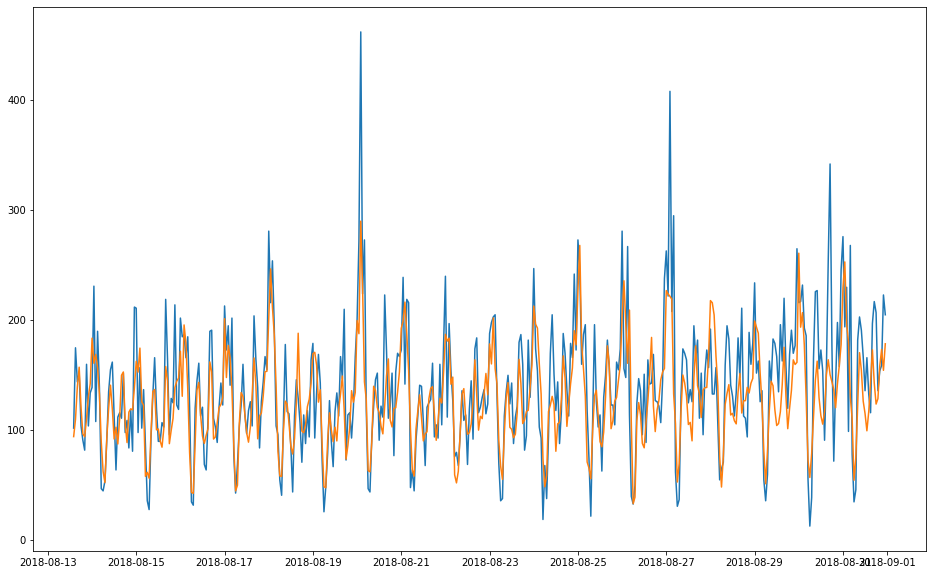

In [109]:
plt.figure(figsize=(16, 10))
plt.plot(result);

In [114]:
RMSE_CatBoost_train = (mean_squared_error(train_target, modelCat.predict(train_features)))**0.5
RMSE_LightGBM_train = (mean_squared_error(train_target, modelLight.predict(train_features)))**0.5
RMSE_XGB_train = (mean_squared_error(train_target, modelXGB.predict(train_features)))**0.5

In [115]:
RMSE_CatBoost_test = (mean_squared_error(test_target, modelCat.predict(test_features)))**0.5
RMSE_LightGBM_test = (mean_squared_error(test_target, modelLight.predict(test_features)))**0.5
RMSE_XGB_test = (mean_squared_error(test_target, modelXGB.predict(test_features)))**0.5

In [116]:
report = pd.DataFrame(columns = ["CatBoost","LGBM","XGB"],
                      index = ["RMSE(train)",
                               "RMSE(test)"])


report.iloc[0] = [RMSE_XGB_train, RMSE_CatBoost_train, RMSE_LightGBM_train]
report.iloc[1] = [RMSE_XGB_test, RMSE_CatBoost_test, RMSE_LightGBM_test]

In [117]:
display(report)

,CatBoost,LGBM,XGB
RMSE(train),16.1015,10.0554,14.8414
RMSE(test),42.4777,40.0336,41.3284


Было принято решение заново пересчитать с альтернативными параметрами и дополнить моделью XGBRegressor, резульатты не сильно отличаются от первоначального вида; разница в ошибках на трейне и тесте при этом сохранилась

In [118]:
RF = RandomForestRegressor(random_state = 12345)
RF_param = {"max_depth": [1,10], "n_estimators":[100,150,10]}

RF_grid = GridSearchCV(RF, RF_param, cv = splits, verbose = True, n_jobs = -1)
RF_grid.fit(train_features, train_target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   16.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_st

In [119]:
CatBoost = CatBoostRegressor(loss_function = 'RMSE', random_state = 12345)
Cat_param = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = CatBoost.grid_search(Cat_param,
            Pool(train_features,train_target),cv = splits,verbose = True)

0:	loss: 31.9154939	best: 31.9154939 (0)	total: 28.9s	remaining: 4m 19s
1:	loss: 32.6917724	best: 31.9154939 (0)	total: 55.5s	remaining: 3m 42s
2:	loss: 33.4145854	best: 31.9154939 (0)	total: 1m 24s	remaining: 3m 16s
3:	loss: 32.6627115	best: 31.9154939 (0)	total: 1m 48s	remaining: 2m 42s
4:	loss: 33.2425803	best: 31.9154939 (0)	total: 2m 7s	remaining: 2m 7s
5:	loss: 37.0317017	best: 31.9154939 (0)	total: 4m 27s	remaining: 2m 58s
6:	loss: 37.8087626	best: 31.9154939 (0)	total: 6m 47s	remaining: 2m 54s
7:	loss: 39.8071187	best: 31.9154939 (0)	total: 9m 7s	remaining: 2m 16s
8:	loss: 38.7353507	best: 31.9154939 (0)	total: 11m 28s	remaining: 1m 16s
9:	loss: 40.3253963	best: 31.9154939 (0)	total: 13m 51s	remaining: 0us
Estimating final quality...


In [120]:
%%time
lgb_train = lgb.Dataset(train_features, train_target)
#lgb_valid = lgb.Dataset(valid_features, valid_target, reference = lgb_train)
lgb_param = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(lgb_param,
                lgb_train,
                num_boost_round = 1000,
             #   valid_sets = [lgb_train,lgb_valid],
                verbose_eval = 100)

CPU times: user 2.73 s, sys: 52.3 ms, total: 2.79 s
Wall time: 2.78 s


In [121]:
%%time
final_cat = CatBoostRegressor(depth = catboost_grid["params"]["depth"], 
                              learning_rate = catboost_grid["params"]['learning_rate'],
                              loss_function = 'RMSE', verbose = 100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 36.9284727	total: 2.21ms	remaining: 2.21s
100:	learn: 20.3177157	total: 2s	remaining: 17.8s
200:	learn: 17.4174731	total: 3.94s	remaining: 15.7s
300:	learn: 15.6652620	total: 5.91s	remaining: 13.7s
400:	learn: 14.2845871	total: 7.82s	remaining: 11.7s
500:	learn: 13.0424149	total: 9.96s	remaining: 9.92s
600:	learn: 11.9575072	total: 11.9s	remaining: 7.91s
700:	learn: 11.0063640	total: 13.9s	remaining: 5.91s
800:	learn: 10.1980139	total: 15.9s	remaining: 3.95s
900:	learn: 9.3601969	total: 18.4s	remaining: 2.02s
999:	learn: 8.6779611	total: 21.2s	remaining: 0us
CPU times: user 18.7 s, sys: 3.08 s, total: 21.8 s
Wall time: 22.7 s


### Выводы по шагу 3

В результате были найдены наилучшие гиперпараметры 

Модели обучены и были пройдены валидация

Подготовка к тестированию завершена

## 4. Тестирование

In [122]:
#RF_valid_prediction = RF_grid.best_estimator_.predict(valid_features)

#Cat_valid_prediction = final_cat.predict(valid_features)

#Light_valid_prediction = light.predict(valid_features)

RF_test_start_time = time.time()
RF_test_prediction = RF_grid.best_estimator_.predict(test_features)
RF_test_total_time = time.time() - RF_test_start_time
    
CatBoost_test_start_time = time.time()
Cat_test_prediction = final_cat.predict(test_features)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time

LightGBM_test_start_time = time.time()
Light_test_prediction = light.predict(test_features)
LightGBM_test_total_time = time.time() - LightGBM_test_start_time

RF_train_prediction = RF_grid.best_estimator_.predict(train_features)

Cat_train_prediction = final_cat.predict(train_features)

Light_train_prediction = light.predict(train_features)

In [123]:
RMSE_RF_train = (mean_squared_error(train_target, RF_train_prediction))**0.5
    
RMSE_CatBoost_train = (mean_squared_error(train_target, Cat_train_prediction))**0.5
    
RMSE_LightGBM_train = (mean_squared_error(train_target, Light_train_prediction))**0.5

#RMSE_RF_valid = (mean_squared_error(valid_target, RF_valid_prediction))**0.5
    
#RMSE_CatBoost_valid = (mean_squared_error(valid_target, Cat_valid_prediction))**0.5
    
#RMSE_LightGBM_valid = (mean_squared_error(valid_target, Light_valid_prediction))**0.5

RMSE_RF_test = (mean_squared_error(test_target, RF_test_prediction))**0.5
    
RMSE_CatBoost_test = (mean_squared_error(test_target, Cat_test_prediction))**0.5
    
RMSE_LightGBM_test = (mean_squared_error(test_target, Light_test_prediction))**0.5

In [124]:
report = pd.DataFrame(columns = ["RandomForest","CatBoost","LightGBM"],
                      index = ["RMSE(train)",
                    #           "RMSE(valid)",
                               "RMSE(test)",
                               "Время обучения (сек.)",
                               "Время предсказания (сек.)"])


report.iloc[0] = [RMSE_RF_train, RMSE_CatBoost_train, RMSE_LightGBM_train]
#report.iloc[1] = [RMSE_RF_valid, RMSE_CatBoost_valid, RMSE_LightGBM_valid]
report.iloc[1] = [RMSE_RF_test, RMSE_CatBoost_test, RMSE_LightGBM_test]
report.iloc[2] = [16.5, 19.5, 236]
report.iloc[3] = [RF_test_total_time, CatBoost_test_total_time, LightGBM_test_total_time]

In [125]:
display(report)

,RandomForest,CatBoost,LightGBM
RMSE(train),14.279,8.67796,0.604046
RMSE(test),44.4147,40.3786,39.2372
Время обучения (сек.),16.5,19.5,236
Время предсказания (сек.),0.0162859,0.00246048,0.0494533


## Итоговый вывод

Во время выполнения проекта были изучены способы предсказания временных рядов за счет регрессоров.

Исходя из финальной таблицы мы видим, что по условию RMSE нам подходят по сути все модели, однако, наименьшую ошибку, как и минимальное время обучения показала модель, построенная на алгоритме LightGBM. Это единственная модель, которая имеет достаточно низкое RMSE = 45. Это означает, что модель в среднем ошибается на 45 заказов такси в час.